In [17]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from pypfopt import risk_models, EfficientFrontier, black_litterman, BlackLittermanModel, expected_returns, objective_functions
from pypfopt import DiscreteAllocation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  15 of 15 completed


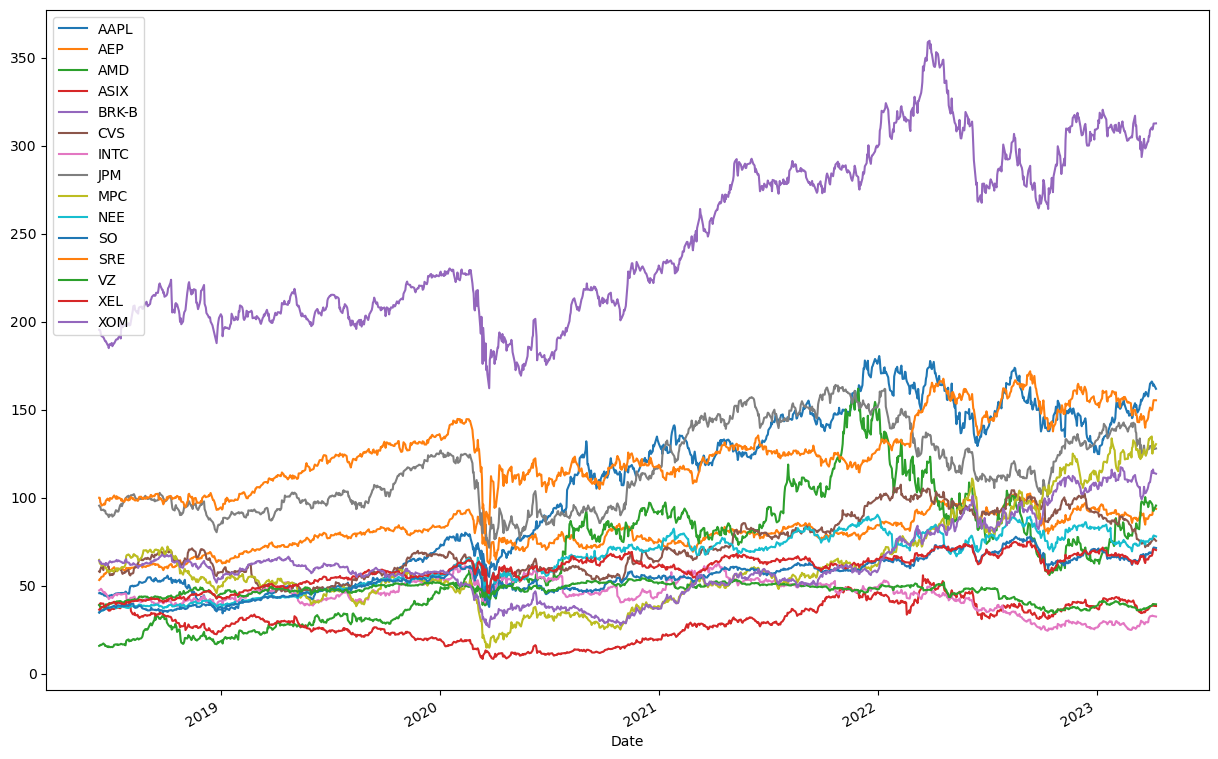

In [28]:
tickers = ["AAPL", "AEP", "AMD", "ASIX", "BRK-B", "CVS", "INTC", "JPM", "MPC", "NEE", "SO", "SRE", "VZ", "XEL", "XOM"]

start_date = "2018-06-11"
end_date = "2023-04-11"
ohlc = yf.download(tickers, start=start_date, end=end_date)["Adj Close"].dropna(how="all")
ohlc[ohlc.index >= "2018-06-11"].plot(figsize=(15,10));

Mean Variance Optimization with Random Forest Regressor

In [136]:
mv_rgr_preds = {}

for ticker in tickers:

    # Dependent variable - 10 consecutive days of stock prices
    stock_x = [ohlc[ticker][i:i+10] for i in range(len(ohlc[ticker])-20)]
    # Independent variable - stock price 10th day into the future
    stock_y = [ohlc[ticker][i+10] for i in range(10,len(ohlc[ticker])-10)]

    stock_test = [ohlc[ticker][i:i+10] for i in range(len(ohlc[ticker])-20,len(ohlc[ticker])-10)]

    reg = RandomForestRegressor()
    reg.fit(stock_x,stock_y)
    # Predict stock price for 10 future days
    mv_rgr_preds[ticker] = reg.predict(stock_test)

mv_rgr_preds = pd.DataFrame(mv_rgr_preds)


# Construct covariance matrix of future stock prices
# cov_matrix = risk_models.sample_cov(future_prices)
S = risk_models.CovarianceShrinkage(mv_rgr_preds).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)

# Use capm to find expected returns on future prices
mu = expected_returns.capm_return(mv_rgr_preds)
print(mu)
# Do mean variance optimization using efficient frontier
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)
# weights = ef.max_sharpe(risk_free_rate=0.02)
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)

AAPL     1.870146
AEP      4.074628
AMD      2.585426
ASIX     3.967262
BRK-B    0.402431
CVS     -0.115162
INTC     3.462793
JPM      1.011387
MPC      0.725973
NEE      4.946772
SO      -0.138578
SRE     -1.304298
VZ       3.282338
XEL      0.953637
XOM     -0.116219
Name: mkt, dtype: float64
OrderedDict([('AAPL', 0.0653), ('AEP', 0.04687), ('AMD', 0.06387), ('ASIX', 0.04675), ('BRK-B', 0.07804), ('CVS', 0.08143), ('INTC', 0.05832), ('JPM', 0.07096), ('MPC', 0.07573), ('NEE', 0.03656), ('SO', 0.08208), ('SRE', 0.08429), ('VZ', 0.0579), ('XEL', 0.07065), ('XOM', 0.08123)])


In [137]:
ef.portfolio_performance(verbose=True)

Expected annual return: 132.2%
Annual volatility: 6.1%
Sharpe Ratio: 21.21


(1.3220028591144306, 0.061400263400428416, 21.20516732352236)

Mean Variance Optimization with Ridge

In [138]:
mv_ridge_preds = {}

for ticker in tickers:

    # Dependent variable - 10 consecutive days of stock prices
    stock_x = [ohlc[ticker][i:i+10] for i in range(len(ohlc[ticker])-20)]
    # Independent variable - stock price 10th day into the future
    stock_y = [ohlc[ticker][i+10] for i in range(10,len(ohlc[ticker])-10)]

    stock_test = [ohlc[ticker][i:i+10] for i in range(len(ohlc[ticker])-20,len(ohlc[ticker])-10)]

    reg = Ridge()
    reg.fit(stock_x,stock_y)
    # Predict stock price for 10 future days
    mv_ridge_preds[ticker] = reg.predict(stock_test)

mv_ridge_preds = pd.DataFrame(mv_ridge_preds)


# Construct covariance matrix of future stock prices
# cov_matrix = risk_models.sample_cov(future_prices)
S = risk_models.CovarianceShrinkage(mv_ridge_preds).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)

# Use capm to find expected returns on future prices
mu = expected_returns.capm_return(mv_ridge_preds)
print(mu)
# Do mean variance optimization using efficient frontier
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)
# weights = ef.max_sharpe(risk_free_rate=0.02)
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)

AAPL      1.328758
AEP       3.998142
AMD       0.316491
ASIX      4.417050
BRK-B     0.302025
CVS       2.120112
INTC      5.433948
JPM       0.360556
MPC      14.313805
NEE       1.610764
SO        2.689164
SRE       1.519177
VZ        0.596940
XEL       3.199899
XOM       4.168592
Name: mkt, dtype: float64
OrderedDict([('AAPL', 0.07387), ('AEP', 0.02857), ('AMD', 0.08745), ('ASIX', 0.03074), ('BRK-B', 0.12197), ('CVS', 0.08628), ('INTC', 0.0), ('JPM', 0.11138), ('MPC', 0.0), ('NEE', 0.08535), ('SO', 0.05468), ('SRE', 0.09473), ('VZ', 0.11439), ('XEL', 0.04706), ('XOM', 0.06351)])


In [139]:
ef.portfolio_performance(verbose=True)

Expected annual return: 154.8%
Annual volatility: 6.3%
Sharpe Ratio: 24.35


(1.5478523107828979, 0.06274380866742073, 24.350646593378134)

Mean Variance Optimization with LASSO

In [298]:
mv_lasso_preds = {}

for ticker in tickers:

    # Dependent variable - 10 consecutive days of stock prices
    stock_x = [ohlc[ticker][i:i+10] for i in range(len(ohlc[ticker])-20)]
    # Independent variable - stock price 10th day into the future
    stock_y = [ohlc[ticker][i+10] for i in range(10,len(ohlc[ticker])-10)]

    stock_test = [ohlc[ticker][i:i+10] for i in range(len(ohlc[ticker])-20,len(ohlc[ticker])-10)]

    reg = Lasso()
    reg.fit(stock_x,stock_y)
    # Predict stock price for 10 future days
    mv_lasso_preds[ticker] = reg.predict(stock_test)

mv_lasso_preds = pd.DataFrame(mv_lasso_preds)


# Construct covariance matrix of future stock prices
# cov_matrix = risk_models.sample_cov(future_prices)
S = risk_models.CovarianceShrinkage(mv_lasso_preds).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)

# Use capm to find expected returns on future prices
mu = expected_returns.capm_return(mv_lasso_preds)
print(mu)
# Do mean variance optimization using efficient frontier
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)
best_weights = weights #because this model performed the best
# weights = ef.max_sharpe(risk_free_rate=0.02)
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)

AAPL      1.488239
AEP       2.964193
AMD       0.690503
ASIX      3.975240
BRK-B     1.217333
CVS       2.407261
INTC      5.680195
JPM       1.704571
MPC      13.330798
NEE       1.345165
SO        1.619135
SRE       1.825648
VZ        0.995608
XEL       2.807806
XOM       4.149032
Name: mkt, dtype: float64
OrderedDict([('AAPL', 0.07808), ('AEP', 0.0509), ('AMD', 0.08597), ('ASIX', 0.04025), ('BRK-B', 0.10427), ('CVS', 0.07163), ('INTC', 0.0), ('JPM', 0.101), ('MPC', 0.0), ('NEE', 0.08736), ('SO', 0.08024), ('SRE', 0.08067), ('VZ', 0.1097), ('XEL', 0.0484), ('XOM', 0.06154)])


In [299]:
ef.portfolio_performance(verbose=True)

Expected annual return: 185.3%
Annual volatility: 6.3%
Sharpe Ratio: 29.05


(1.8531071491741171, 0.06309822872922877, 29.05164195718498)

Black Litterman Optimization with Random Forest Regression

In [154]:
bl_rfr_preds = {}

for ticker in tickers:
# Fit non linear ML models to predict stock returns into future
    stock_returns = (
        (ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    stock_x = [stock_returns[i:i+10] for i in range(len(stock_returns)-20)]
    stock_y = [stock_returns[i+10] for i in range(10,len(stock_returns)-10)]

    stock_test = [stock_returns[i:i+10] for i in range(len(stock_returns)-20,len(stock_returns)-10)]

    reg = RandomForestRegressor()
    reg.fit(stock_x,stock_y)
    bl_rfr_preds[ticker] = reg.predict(stock_test)

# Use predicted future returns as views for BL model
viewdict = {}
for key in bl_rfr_preds.keys():
    viewdict[key] = bl_rfr_preds[key][-1]

print("viewdict: ", viewdict)
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
#print(mcaps)

S = risk_models.CovarianceShrinkage(ohlc).ledoit_wolf()
market_prices = yf.download("SPY", period="max")["Adj Close"]


delta = black_litterman.market_implied_risk_aversion(market_prices)
#print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
#print(market_prior)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
     0.05,
     0.5,
    0.1,
    0.4,
    0.05,
    0.4,
    0.2,
    0.05,
    0.6,
    0.5,
    0.1,
    0.10,
    0.30,
    0.30,
    0.10
]

# Fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Get expected returns
ret_bl = bl.bl_returns()
#print(ret_bl)

# Get cov matrix
S_bl = bl.bl_cov()

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print(weights)


viewdict:  {'AAPL': -0.0010277223753744691, 'AEP': 0.009569552435385136, 'AMD': -0.0025946582163581954, 'ASIX': -0.005928997483912022, 'BRK-B': -0.0008967741595439149, 'CVS': -0.0012010037183087152, 'INTC': 0.0033872583951652015, 'JPM': 0.0020325333804222913, 'MPC': 0.0012351959232663257, 'NEE': -0.000275302454107077, 'SO': -0.001003449333140577, 'SRE': 0.0023229821856786503, 'VZ': -0.003938879803585941, 'XEL': 0.005631761679415403, 'XOM': 0.0015428005539077272}
[*********************100%***********************]  1 of 1 completed
OrderedDict([('AAPL', 0.35518), ('AEP', 0.0), ('AMD', 0.25527), ('ASIX', 0.02518), ('BRK-B', 0.08657), ('CVS', 0.00281), ('INTC', 0.14049), ('JPM', 0.08857), ('MPC', 0.0), ('NEE', 0.0), ('SO', 0.0), ('SRE', 0.00117), ('VZ', 0.0), ('XEL', 0.0), ('XOM', 0.04476)])


In [155]:
ef.portfolio_performance(verbose=True)

Expected annual return: 11.1%
Annual volatility: 31.4%
Sharpe Ratio: 0.29


(0.11092605070409714, 0.31389362149946237, 0.289671546270184)

Black Litterman Optimization with Ridge

In [159]:
bl_ridge_preds = {}

for ticker in tickers:
# Fit non linear ML models to predict stock returns into future
    stock_returns = (
        (ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    stock_x = [stock_returns[i:i+10] for i in range(len(stock_returns)-20)]
    stock_y = [stock_returns[i+10] for i in range(10,len(stock_returns)-10)]

    stock_test = [stock_returns[i:i+10] for i in range(len(stock_returns)-20,len(stock_returns)-10)]

    reg = Ridge()
    reg.fit(stock_x,stock_y)
    bl_ridge_preds[ticker] = reg.predict(stock_test)

# Use predicted future returns as views for BL model
viewdict = {}
for key in bl_ridge_preds.keys():
    viewdict[key] = bl_ridge_preds[key][-1]

print("viewdict: ", viewdict)
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
#print(mcaps)

S = risk_models.CovarianceShrinkage(ohlc).ledoit_wolf()
market_prices = yf.download("SPY", period="max")["Adj Close"]


delta = black_litterman.market_implied_risk_aversion(market_prices)
#print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
#print(market_prior)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
     0.1,
     0.4,
    0.2,
    0.4,
    0.05,
    0.3,
    0.3,
    0.05,
    0.5,
    0.5,
    0.2,
    0.10,
    0.20,
    0.20,
    0.10
]

# Fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Get expected returns
ret_bl = bl.bl_returns()
#print(ret_bl)

# Get cov matrix
S_bl = bl.bl_cov()

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print(weights)


viewdict:  {'AAPL': 0.0007508704123551483, 'AEP': -0.00044827164256658987, 'AMD': 0.002815775587035164, 'ASIX': 0.0011829211222804188, 'BRK-B': 0.0005146470999434209, 'CVS': 0.0006183243776435848, 'INTC': -0.0011081633662279806, 'JPM': 0.0010739198688294311, 'MPC': 0.001443896064850452, 'NEE': 0.0002850147104006429, 'SO': -0.0008596390018301324, 'SRE': -0.00016194666071624988, 'VZ': -0.0002619175685383145, 'XEL': -0.0004453468641738259, 'XOM': 0.0013065053475527616}
[*********************100%***********************]  1 of 1 completed
OrderedDict([('AAPL', 0.34197), ('AEP', 0.0), ('AMD', 0.21881), ('ASIX', 0.03293), ('BRK-B', 0.09145), ('CVS', 0.01982), ('INTC', 0.11345), ('JPM', 0.09727), ('MPC', 0.02319), ('NEE', 0.0), ('SO', 0.0), ('SRE', 0.00304), ('VZ', 0.0), ('XEL', 0.0), ('XOM', 0.05808)])


In [160]:
ef.portfolio_performance(verbose=True)

Expected annual return: 9.7%
Annual volatility: 29.9%
Sharpe Ratio: 0.26


(0.09744088360625427, 0.2994366556684159, 0.25862192266804235)

Black Litterman Optimization with LASSO

In [161]:
bl_ridge_preds = {}

for ticker in tickers:
# Fit non linear ML models to predict stock returns into future
    stock_returns = (
        (ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    stock_x = [stock_returns[i:i+10] for i in range(len(stock_returns)-20)]
    stock_y = [stock_returns[i+10] for i in range(10,len(stock_returns)-10)]

    stock_test = [stock_returns[i:i+10] for i in range(len(stock_returns)-20,len(stock_returns)-10)]

    reg = Lasso(alpha=0.2)
    reg.fit(stock_x,stock_y)
    bl_ridge_preds[ticker] = reg.predict(stock_test)

# Use predicted future returns as views for BL model
viewdict = {}
for key in bl_ridge_preds.keys():
    viewdict[key] = bl_ridge_preds[key][-1]

print("viewdict: ", viewdict)
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
#print(mcaps)

S = risk_models.CovarianceShrinkage(ohlc).ledoit_wolf()
market_prices = yf.download("SPY", period="max")["Adj Close"]


delta = black_litterman.market_implied_risk_aversion(market_prices)
#print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
#print(market_prior)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
     0.1,
     0.3,
    0.5,
    0.3,
    0.05,
    0.4,
    0.3,
    0.05,
    0.5,
    0.6,
    0.2,
    0.20,
    0.20,
    0.20,
    0.20
]

# Fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Get expected returns
ret_bl = bl.bl_returns()
#print(ret_bl)

# Get cov matrix
S_bl = bl.bl_cov()

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print(weights)


viewdict:  {'AAPL': 0.0012909973354070041, 'AEP': 0.0005028920389256806, 'AMD': 0.002118328578334849, 'ASIX': 0.0006123097721237437, 'BRK-B': 0.0005224797969951067, 'CVS': 0.0003636620410291986, 'INTC': 1.4058935124171877e-05, 'JPM': 0.000483495608662224, 'MPC': 0.0011318567293243556, 'NEE': 0.000767121350311992, 'SO': 0.0006621883450856808, 'SRE': 0.0005169131119190186, 'VZ': 4.208345619571525e-05, 'XEL': 0.0005982093624628777, 'XOM': 0.0007110138735041979}
[*********************100%***********************]  1 of 1 completed
OrderedDict([('AAPL', 0.39159), ('AEP', 0.0), ('AMD', 0.1365), ('ASIX', 0.05541), ('BRK-B', 0.1019), ('CVS', 0.00413), ('INTC', 0.12173), ('JPM', 0.11129), ('MPC', 0.01833), ('NEE', 0.0), ('SO', 0.0), ('SRE', 0.0), ('VZ', 0.0), ('XEL', 0.0), ('XOM', 0.05912)])


In [162]:
ef.portfolio_performance(verbose=True)

Expected annual return: 8.4%
Annual volatility: 28.7%
Sharpe Ratio: 0.22


(0.0844728595404523, 0.2866482434290997, 0.22491977892199844)

CAPM with Ridge Regression

In [41]:
# T-bill rate
from sklearn.neural_network import MLPRegressor

risk_free_rate = 0.01
ohlc_market = yf.download(["SPY"], start=start_date, end=end_date)["Adj Close"].dropna(how="all")
market_returns = (
    (ohlc_market / ohlc_market.shift(1))-1-risk_free_rate).dropna().tolist()

market_x = [market_returns[i:i+10] for i in range(len(market_returns)-20)]
market_y = [market_returns[i+10] for i in range(10, len(market_returns)-10)]

market_test = [market_returns[i:i+10]
               for i in range(len(market_returns)-20, len(market_returns)-10)]

reg = MLPRegressor(hidden_layer_sizes=(100,100))
reg.fit(market_x, market_y)
market_future = reg.predict(market_test)
print("market future: ",market_future)

stock_futures = {}

for ticker in tickers:
    stock_returns = (
        (ohlc[ticker] / ohlc[ticker].shift(1))-1-risk_free_rate).dropna().tolist()

    single_index_reg = Ridge()
    single_index_reg.fit(np.array(market_returns).reshape(-1, 1), stock_returns)
    stock_futures[ticker] = single_index_reg.predict(np.array(market_future).reshape(-1, 1))

future_returns = pd.DataFrame(stock_futures)
print("future_returns: ",future_returns)

S = risk_models.sample_cov(future_returns)
# S = risk_models.CovarianceShrinkage(future_returns).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)
# You don't have to provide expected returns in this case


ef = EfficientFrontier(None, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)
# weights = ef.max_sharpe(risk_free_rate=-0.2)
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)
# print(mu)

[*********************100%***********************]  1 of 1 completed
market future:  [-0.00838268 -0.011437   -0.01097692 -0.00939963 -0.00967276 -0.01353724
 -0.01020826 -0.013151   -0.01371457 -0.01012473]
future_returns:         AAPL       AEP       AMD      ASIX     BRK-B       CVS      INTC  \
0 -0.008471 -0.009302 -0.007528 -0.009162 -0.009328 -0.009470 -0.009765   
1 -0.009177 -0.009616 -0.008442 -0.009870 -0.009814 -0.009879 -0.010452   
2 -0.009070 -0.009569 -0.008304 -0.009763 -0.009741 -0.009817 -0.010348   
3 -0.008706 -0.009407 -0.007832 -0.009398 -0.009490 -0.009606 -0.009993   
4 -0.008769 -0.009435 -0.007914 -0.009461 -0.009533 -0.009643 -0.010055   
5 -0.009662 -0.009832 -0.009070 -0.010357 -0.010147 -0.010161 -0.010924   
6 -0.008893 -0.009490 -0.008074 -0.009585 -0.009618 -0.009714 -0.010175   
7 -0.009573 -0.009792 -0.008955 -0.010268 -0.010086 -0.010109 -0.010837   
8 -0.009703 -0.009850 -0.009123 -0.010398 -0.010175 -0.010185 -0.010964   
9 -0.008873 -0.009481 -0.

In [42]:
ef.portfolio_performance(verbose=True)

Annual volatility: 34.3%


(None, 0.34344916824348665, None)

CAPM with LASSO

In [43]:
# T-bill rate
risk_free_rate = 0.01
ohlc_market = yf.download(["SPY"], start=start_date, end=end_date)["Adj Close"].dropna(how="all")
market_returns = (
    (ohlc_market / ohlc_market.shift(1))-1-risk_free_rate).dropna().tolist()

market_x = [market_returns[i:i+10] for i in range(len(market_returns)-20)]
market_y = [market_returns[i+10] for i in range(10, len(market_returns)-10)]

market_test = [market_returns[i:i+10]
               for i in range(len(market_returns)-20, len(market_returns)-10)]

reg = MLPRegressor(hidden_layer_sizes=(100,100))
reg.fit(market_x, market_y)
market_future = reg.predict(market_test)
print("market future: ",market_future)

stock_futures = {}

for ticker in tickers:
    stock_returns = (
        (ohlc[ticker] / ohlc[ticker].shift(1))-1-risk_free_rate).dropna().tolist()

    single_index_reg = Lasso()
    single_index_reg.fit(np.array(market_returns).reshape(-1, 1), stock_returns)
    stock_futures[ticker] = single_index_reg.predict(np.array(market_future).reshape(-1, 1))

future_returns = pd.DataFrame(stock_futures)
print("future_returns: ",future_returns)

S = risk_models.sample_cov(future_returns)
# S = risk_models.CovarianceShrinkage(future_returns).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)
# You don't have to provide expected returns in this case


ef = EfficientFrontier(None, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)
# weights = ef.max_sharpe(risk_free_rate=-0.2)
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)
# print(mu)

[*********************100%***********************]  1 of 1 completed
market future:  [-0.01219781 -0.00926249 -0.00751795 -0.01167283 -0.00994208 -0.01207558
 -0.01184159 -0.01181355 -0.01054093 -0.01129018]
future_returns:         AAPL       AEP       AMD      ASIX     BRK-B       CVS     INTC  \
0 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
1 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
2 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
3 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
4 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
5 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
6 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
7 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
8 -0.008733 -0.009419 -0.007868 -0.009425 -0.009509 -0.009622 -0.01002   
9 -0.008733 -0.009419 -0.007868 -0.

In [44]:
ef.portfolio_performance(verbose=True)

Annual volatility: 0.0%


(None, 0.0, None)

CAPM with Decision Tree Regressor

In [50]:
# T-bill rate
risk_free_rate = 0.01
ohlc_market = yf.download(["SPY"], start=start_date, end=end_date)["Adj Close"].dropna(how="all")
market_returns = (
    (ohlc_market / ohlc_market.shift(1))-1-risk_free_rate).dropna().tolist()

market_x = [market_returns[i:i+10] for i in range(len(market_returns)-20)]
market_y = [market_returns[i+10] for i in range(10, len(market_returns)-10)]

market_test = [market_returns[i:i+10]
               for i in range(len(market_returns)-20, len(market_returns)-10)]

reg = MLPRegressor(hidden_layer_sizes=(100,100))
reg.fit(market_x, market_y)
market_future = reg.predict(market_test)
print("market future: ",market_future)

stock_futures = {}

for ticker in tickers:
    stock_returns = (
        (ohlc[ticker] / ohlc[ticker].shift(1))-1-risk_free_rate).dropna().tolist()

    single_index_reg = DecisionTreeRegressor()
    single_index_reg.fit(np.array(market_returns).reshape(-1, 1), stock_returns)
    stock_futures[ticker] = single_index_reg.predict(np.array(market_future).reshape(-1, 1))

future_returns = pd.DataFrame(stock_futures)
print("future_returns: ",future_returns)

S = risk_models.sample_cov(future_returns)
# S = risk_models.CovarianceShrinkage(future_returns).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)
# You don't have to provide expected returns in this case


ef = EfficientFrontier(None, S)
#ef.min_volatility()
#print(weights)
# weights = ef.max_sharpe(risk_free_rate=-0.2)
# cleaned_weights = ef.clean_weights()
# print(cleaned_weights)
# print(mu)

[*********************100%***********************]  1 of 1 completed
market future:  [-0.00910001 -0.00771746 -0.00881122 -0.00954643 -0.00765302 -0.00838428
 -0.00965415 -0.00954221 -0.00712401 -0.00782961]
future_returns:         AAPL       AEP       AMD      ASIX     BRK-B       CVS      INTC  \
0 -0.005425 -0.012953 -0.005342 -0.028515 -0.007967 -0.002701 -0.032870   
1 -0.013841 -0.008752 -0.006965 -0.011514 -0.008063 -0.004696 -0.009102   
2 -0.011111  0.007194 -0.017380 -0.031922 -0.007714 -0.021918 -0.003247   
3 -0.008253 -0.003336 -0.042792 -0.044354 -0.010329  0.009219 -0.018569   
4 -0.011949 -0.017343  0.011021 -0.002449 -0.009856 -0.022463  0.014086   
5 -0.011920 -0.023248 -0.006643 -0.015167 -0.010667 -0.013115  0.020581   
6 -0.009933  0.000485 -0.019466 -0.021330 -0.014615 -0.015637 -0.009801   
7 -0.008253 -0.003336 -0.042792 -0.044354 -0.010329  0.009219 -0.018569   
8 -0.012020  0.018440 -0.007815  0.019075 -0.011309 -0.004307  0.004542   
9 -0.001667 -0.006061 -0.

Single Index with RandomForestRegressor

In [232]:
stock_future = {}
beta = {}
alpha = {}
residual_variance = {}
residuals = {}
y_pred = {}
w = {}
w_scaled = {}
final_weight = {}

# Future market returns prediction
market_x = [market_returns[i:i+10] for i in range(len(market_returns)-20)]
market_y = [market_returns[i+10] for i in range(10, len(market_returns)-10)]

market_test = [market_returns[i:i+10]
                for i in range(len(market_returns)-20, len(market_returns)-10)]

reg = RandomForestRegressor()
reg.fit(market_x, market_y)
market_future = reg.predict(market_test)

for ticker in tickers:
    stock_returns = ((ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    # Fitting single index model regression on market return and stock return
    single_index_reg_stock = LinearRegression()
    single_index_reg_stock.fit(np.array(market_returns).reshape(-1, 1),y=stock_returns)
    stock_future[ticker] = single_index_reg_stock.predict(np.array(market_future).reshape(-1, 1))

    beta[ticker] = single_index_reg_stock.coef_[0]
    alpha[ticker] = single_index_reg_stock.intercept_
    print("Beta of {}: ".format(ticker), beta[ticker])
    print("Alpha of {}: ".format(ticker), alpha[ticker])

    y_pred[ticker] = single_index_reg_stock.predict(np.array(market_returns).reshape(-1, 1))
    residuals[ticker] = stock_returns - y_pred[ticker]
    residual_variance[ticker] = np.var(residuals[ticker])

    # variance of the residuals for the stock
    print("Residual variance of {}: ".format(ticker), residual_variance[ticker])
    print("-------------------------")

# Using Treynor Black model for portfolio optimization

#STEP 1:
# Compute the initial position of each security:
for ticker in tickers:
    w[ticker] = alpha[ticker]/residual_variance[ticker]
    print("{} Weight: ".format(ticker), w[ticker])

all_w = sum(w.values())

#STEP 2:
# Scale the initial positions:
for ticker in tickers:
    w_scaled[ticker] = w[ticker]/(all_w)
    print("{} Weight Scaled: ".format(ticker), w_scaled[ticker])

#STEP 3:
# Compute the alpha of the active portfolio:
alpha_portfolio = 0
for ticker in tickers:
    alpha_portfolio = alpha_portfolio + (w_scaled[ticker]*alpha[ticker])
print("Alpha of the active portfolio: ", alpha_portfolio)

#STEP 4:
# Compute the residual variance of active portfolio:
residual_variance_portfolio = 0
for ticker in tickers:
    residual_variance_portfolio = residual_variance_portfolio + (w_scaled[ticker]*w_scaled[ticker]*residual_variance[ticker])
print("Residual variance of the active portfolio: ", residual_variance_portfolio)

#STEP 5:
# Compute the initial position in active portfolio:
# Note: The S&P 500’s long-term standard deviation (volatility) is around 12%. Hence, variance of S&P is 0.0114
residual_variance_market = 0.0114
risk_premium_market = 0.056
initial_position_portfolio = (alpha_portfolio*residual_variance_market)/(residual_variance_portfolio*risk_premium_market)
print("Initial position of active portfolio: ", initial_position_portfolio)

#STEP 6:
# Compute the beta of active portfolio:
beta_portfolio = 0
for ticker in tickers:
    beta_portfolio = beta_portfolio + (w_scaled[ticker]*beta[ticker])
print("Beta of the active portfolio: ", beta_portfolio)

#STEP 7:
# Adjust the initial position in active portfolio
adjusted_position_portfolio = initial_position_portfolio/1+(1-beta_portfolio)*initial_position_portfolio
print("Adjusted position of the active portfolio: ", adjusted_position_portfolio)

#STEP 8:
# Optimal risky portfolio now has weights:
final_weight_market = 1-adjusted_position_portfolio
for ticker in tickers:
    final_weight[ticker] = adjusted_position_portfolio*w_scaled[ticker]

print("------------------------------")
print("Final Weights: ")
print("Weight Market S&P: ", final_weight_market)
print("Weight of Stocks: ", final_weight)
print("------------------------------")


#STEP 9:
# Calculate the risk premium of P (Optimal risky portfolio):
risk_premium_porfolio = (final_weight_market+adjusted_position_portfolio*beta_portfolio)*risk_premium_market + adjusted_position_portfolio*alpha_portfolio
print("Risk premium of portfolio: ", risk_premium_porfolio)

#STEP 10:
# Compute the variance of Portfolio:
portfolio_variance = (final_weight_market+adjusted_position_portfolio*beta_portfolio)*(final_weight_market+adjusted_position_portfolio*beta_portfolio)*residual_variance_market + adjusted_position_portfolio*adjusted_position_portfolio*residual_variance_portfolio
print("Variance of portfolio: ", portfolio_variance)

print("stock future")
print(stock_future)

S = risk_models.CovarianceShrinkage(stock_future).ledoit_wolf()
mu = expected_returns.capm_return(stock_future)
print(mu)
# Do mean variance optimization using efficient frontier
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)

Beta of AAPL:  1.2557967022945096
Alpha of AAPL:  0.01322072081088279
Residual variance of AAPL:  0.0001573783006005267
-------------------------
Beta of AEP:  0.5581328797319195
Alpha of AEP:  0.005894085612452534
Residual variance of AEP:  0.00017260632233443782
-------------------------
Beta of ASIX:  1.2592213592101547
Alpha of ASIX:  0.012561213951579627
Residual variance of ASIX:  0.0008758007278047358
-------------------------
Beta of CVS:  0.7281614873177585
Alpha of CVS:  0.007309459552135101
Residual variance of CVS:  0.00022628502429826683
-------------------------
Beta of INTC:  1.2218009493266857
Alpha of INTC:  0.011610081285374869
Residual variance of INTC:  0.00030043851515144715
-------------------------
Beta of JPM:  1.1069634303555183
Alpha of JPM:  0.010986453539342961
Residual variance of JPM:  0.00018944845968890507
-------------------------
Beta of MPC:  1.3188789724443801
Alpha of MPC:  0.013604860716541274
Residual variance of MPC:  0.0006113009599601357
------

In [233]:
ef.portfolio_performance(verbose=True)

Expected annual return: 1975435529333094553223168.0%
Annual volatility: 4262.6%
Sharpe Ratio: 463437497042818629632.00


(1.9754355293330946e+22, 42.62571634661183, 4.634374970428186e+20)

Single Index with LASSO

In [52]:
stock_future = {}
beta = {}
alpha = {}
residual_variance = {}
residuals = {}
y_pred = {}
w = {}
w_scaled = {}
final_weight = {}

# Future market returns prediction
market_x = [market_returns[i:i+10] for i in range(len(market_returns)-20)]
market_y = [market_returns[i+10] for i in range(10, len(market_returns)-10)]

market_test = [market_returns[i:i+10]
                for i in range(len(market_returns)-20, len(market_returns)-10)]

reg = RandomForestRegressor()
reg.fit(market_x, market_y)
market_future = reg.predict(market_test)

for ticker in tickers:
    stock_returns = ((ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    # Fitting single index model regression on market return and stock return
    single_index_reg_stock = Lasso(alpha=0.1)
    single_index_reg_stock.fit(np.array(market_returns).reshape(-1, 1),y=stock_returns)
    stock_future[ticker] = single_index_reg_stock.predict(np.array(market_future).reshape(-1, 1))

    beta[ticker] = single_index_reg_stock.coef_[0]
    alpha[ticker] = single_index_reg_stock.intercept_
    print("Beta of {}: ".format(ticker), beta[ticker])
    print("Alpha of {}: ".format(ticker), alpha[ticker])

    y_pred[ticker] = single_index_reg_stock.predict(np.array(market_returns).reshape(-1, 1))
    residuals[ticker] = stock_returns - y_pred[ticker]
    residual_variance[ticker] = np.var(residuals[ticker])

    # variance of the residuals for the stock
    print("Residual variance of {}: ".format(ticker), residual_variance[ticker])
    print("-------------------------")

# Using Treynor Black model for portfolio optimization

#STEP 1:
# Compute the initial position of each security:
for ticker in tickers:
    w[ticker] = alpha[ticker]/residual_variance[ticker]
    print("{} Weight: ".format(ticker), w[ticker])

all_w = sum(w.values())

#STEP 2:
# Scale the initial positions:
for ticker in tickers:
    w_scaled[ticker] = w[ticker]/(all_w)
    print("{} Weight Scaled: ".format(ticker), w_scaled[ticker])

#STEP 3:
# Compute the alpha of the active portfolio:
alpha_portfolio = 0
for ticker in tickers:
    alpha_portfolio = alpha_portfolio + (w_scaled[ticker]*alpha[ticker])
print("Alpha of the active portfolio: ", alpha_portfolio)

#STEP 4:
# Compute the residual variance of active portfolio:
residual_variance_portfolio = 0
for ticker in tickers:
    residual_variance_portfolio = residual_variance_portfolio + (w_scaled[ticker]*w_scaled[ticker]*residual_variance[ticker])
print("Residual variance of the active portfolio: ", residual_variance_portfolio)

#STEP 5:
# Compute the initial position in active portfolio:
# Note: The S&P 500’s long-term standard deviation (volatility) is around 12%. Hence, variance of S&P is 0.0114
residual_variance_market = 0.0114
risk_premium_market = 0.056
initial_position_portfolio = (alpha_portfolio*residual_variance_market)/(residual_variance_portfolio*risk_premium_market)
print("Initial position of active portfolio: ", initial_position_portfolio)

#STEP 6:
# Compute the beta of active portfolio:
beta_portfolio = 0
for ticker in tickers:
    beta_portfolio = beta_portfolio + (w_scaled[ticker]*beta[ticker])
print("Beta of the active portfolio: ", beta_portfolio)

#STEP 7:
# Adjust the initial position in active portfolio
adjusted_position_portfolio = initial_position_portfolio/1+(1-beta_portfolio)*initial_position_portfolio
print("Adjusted position of the active portfolio: ", adjusted_position_portfolio)

#STEP 8:
# Optimal risky portfolio now has weights:
final_weight_market = 1-adjusted_position_portfolio
for ticker in tickers:
    final_weight[ticker] = adjusted_position_portfolio*w_scaled[ticker]

print("------------------------------")
print("Final Weights: ")
print("Weight Market S&P: ", final_weight_market)
print("Weight of Stocks: ", final_weight)
print("------------------------------")


#STEP 9:
# Calculate the risk premium of P (Optimal risky portfolio):
risk_premium_porfolio = (final_weight_market+adjusted_position_portfolio*beta_portfolio)*risk_premium_market + adjusted_position_portfolio*alpha_portfolio
print("Risk premium of portfolio: ", risk_premium_porfolio)

#STEP 10:
# Compute the variance of Portfolio:
portfolio_variance = (final_weight_market+adjusted_position_portfolio*beta_portfolio)*(final_weight_market+adjusted_position_portfolio*beta_portfolio)*residual_variance_market + adjusted_position_portfolio*adjusted_position_portfolio*residual_variance_portfolio
print("Variance of portfolio: ", portfolio_variance)

print("stock future")
print(stock_future)

S = risk_models.CovarianceShrinkage(stock_future).ledoit_wolf()
mu = expected_returns.capm_return(stock_future)
print(mu)
# Do mean variance optimization using efficient frontier
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)

Beta of AAPL:  0.0
Alpha of AAPL:  0.0012667078333164108
Residual variance of AAPL:  0.00045032800203874147
-------------------------
Beta of AEP:  0.0
Alpha of AEP:  0.0005811808795785774
Residual variance of AEP:  0.00023047279022622697
-------------------------
Beta of AMD:  0.0
Alpha of AMD:  0.0021319140637776676
Residual variance of AMD:  0.0013017014633862527
-------------------------
Beta of ASIX:  0.0
Alpha of ASIX:  0.0005746012619699805
Residual variance of ASIX:  0.0011703506081877527
-------------------------
Beta of BRK-B:  0.0
Alpha of BRK-B:  0.0004910322212081754
Residual variance of BRK-B:  0.00020766801334999019
-------------------------
Beta of CVS:  0.0
Alpha of CVS:  0.0003780412762885336
Residual variance of CVS:  0.0003247787268415578
-------------------------
Beta of INTC:  0.0
Alpha of INTC:  -2.032396944582705e-05
Residual variance of INTC:  0.0005777421323790533
-------------------------
Beta of JPM:  0.0
Alpha of JPM:  0.0004491944629684404
Residual varianc

Single Index with Ridge

In [55]:
stock_future = {}
beta = {}
alpha = {}
residual_variance = {}
residuals = {}
y_pred = {}
w = {}
w_scaled = {}
final_weight = {}

# Future market returns prediction
market_x = [market_returns[i:i+10] for i in range(len(market_returns)-20)]
market_y = [market_returns[i+10] for i in range(10, len(market_returns)-10)]

market_test = [market_returns[i:i+10]
                for i in range(len(market_returns)-20, len(market_returns)-10)]

reg = RandomForestRegressor()
reg.fit(market_x, market_y)
market_future = reg.predict(market_test)

for ticker in tickers:
    stock_returns = ((ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    # Fitting single index model regression on market return and stock return
    single_index_reg_stock = Ridge()
    single_index_reg_stock.fit(np.array(market_returns).reshape(-1, 1),y=stock_returns)
    stock_future[ticker] = single_index_reg_stock.predict(np.array(market_future).reshape(-1, 1))

    beta[ticker] = single_index_reg_stock.coef_[0]
    alpha[ticker] = single_index_reg_stock.intercept_
    print("Beta of {}: ".format(ticker), beta[ticker])
    print("Alpha of {}: ".format(ticker), alpha[ticker])

    y_pred[ticker] = single_index_reg_stock.predict(np.array(market_returns).reshape(-1, 1))
    residuals[ticker] = stock_returns - y_pred[ticker]
    residual_variance[ticker] = np.var(residuals[ticker])

    # variance of the residuals for the stock
    print("Residual variance of {}: ".format(ticker), residual_variance[ticker])
    print("-------------------------")

# Using Treynor Black model for portfolio optimization

#STEP 1:
# Compute the initial position of each security:
for ticker in tickers:
    w[ticker] = alpha[ticker]/residual_variance[ticker]
    print("{} Weight: ".format(ticker), w[ticker])

all_w = sum(w.values())

#STEP 2:
# Scale the initial positions:
for ticker in tickers:
    w_scaled[ticker] = w[ticker]/(all_w)
    print("{} Weight Scaled: ".format(ticker), w_scaled[ticker])

#STEP 3:
# Compute the alpha of the active portfolio:
alpha_portfolio = 0
for ticker in tickers:
    alpha_portfolio = alpha_portfolio + (w_scaled[ticker]*alpha[ticker])
print("Alpha of the active portfolio: ", alpha_portfolio)

#STEP 4:
# Compute the residual variance of active portfolio:
residual_variance_portfolio = 0
for ticker in tickers:
    residual_variance_portfolio = residual_variance_portfolio + (w_scaled[ticker]*w_scaled[ticker]*residual_variance[ticker])
print("Residual variance of the active portfolio: ", residual_variance_portfolio)

#STEP 5:
# Compute the initial position in active portfolio:
# Note: The S&P 500’s long-term standard deviation (volatility) is around 12%. Hence, variance of S&P is 0.0114
residual_variance_market = 0.0114
risk_premium_market = 0.056
initial_position_portfolio = (alpha_portfolio*residual_variance_market)/(residual_variance_portfolio*risk_premium_market)
print("Initial position of active portfolio: ", initial_position_portfolio)

#STEP 6:
# Compute the beta of active portfolio:
beta_portfolio = 0
for ticker in tickers:
    beta_portfolio = beta_portfolio + (w_scaled[ticker]*beta[ticker])
print("Beta of the active portfolio: ", beta_portfolio)

#STEP 7:
# Adjust the initial position in active portfolio
adjusted_position_portfolio = initial_position_portfolio/1+(1-beta_portfolio)*initial_position_portfolio
print("Adjusted position of the active portfolio: ", adjusted_position_portfolio)

#STEP 8:
# Optimal risky portfolio now has weights:
final_weight_market = 1-adjusted_position_portfolio
for ticker in tickers:
    final_weight[ticker] = adjusted_position_portfolio*w_scaled[ticker]

print("------------------------------")
print("Final Weights: ")
print("Weight Market S&P: ", final_weight_market)
print("Weight of Stocks: ", final_weight)
print("------------------------------")


#STEP 9:
# Calculate the risk premium of P (Optimal risky portfolio):
risk_premium_porfolio = (final_weight_market+adjusted_position_portfolio*beta_portfolio)*risk_premium_market + adjusted_position_portfolio*alpha_portfolio
print("Risk premium of portfolio: ", risk_premium_porfolio)

#STEP 10:
# Compute the variance of Portfolio:
portfolio_variance = (final_weight_market+adjusted_position_portfolio*beta_portfolio)*(final_weight_market+adjusted_position_portfolio*beta_portfolio)*residual_variance_market + adjusted_position_portfolio*adjusted_position_portfolio*residual_variance_portfolio
print("Variance of portfolio: ", portfolio_variance)

print("stock future")
print(stock_future)

S = risk_models.CovarianceShrinkage(stock_future).ledoit_wolf()
mu = expected_returns.capm_return(stock_future)
print(mu)
# Do mean variance optimization using efficient frontier
ef = EfficientFrontier(mu, S)
ef.min_volatility()
weights = ef.clean_weights()
print(weights)

Beta of AAPL:  0.23124153175102952
Alpha of AAPL:  0.003467911585664894
Residual variance of AAPL:  0.00035237406515505157
-------------------------
Beta of AEP:  0.10277409244718956
Alpha of AEP:  0.0015594944040821892
Residual variance of AEP:  0.0002111238349260504
-------------------------
Beta of AMD:  0.2991837550656481
Alpha of AMD:  0.004979864426782828
Residual variance of AMD:  0.0011377307682019291
-------------------------
Beta of ASIX:  0.23187225652192478
Alpha of ASIX:  0.002781808925994194
Residual variance of ASIX:  0.0010718615924114358
-------------------------
Beta of BRK-B:  0.1588681374237898
Alpha of BRK-B:  0.0020033087468730062
Residual variance of BRK-B:  0.00016143376215063847
-------------------------
Beta of CVS:  0.13408317895286445
Alpha of CVS:  0.0016543881089830649
Residual variance of CVS:  0.00029184515640694777
-------------------------
Beta of INTC:  0.22498161822115417
Alpha of INTC:  0.00212129124339162
Residual variance of INTC:  0.0004850198116

In [56]:
ef.portfolio_performance(verbose=True)

Expected annual return: -19.9%
Annual volatility: 10173.2%
Sharpe Ratio: -0.00


(-0.1993367222580414, 101.73238607222225, -0.0021560166897326974)

APT / Multifactor Model with Ridge

In [57]:
# Example tickers for S&P 500, and 20+ Year Treasury Bond ETFs
factor_tickers = ['SPY', 'TLT']

# Fetch historical data for the macroeconomic factors S&P and Treasury Bond
factor_data = yf.download(
    factor_tickers, start=start_date, end=end_date, progress=False)
factor_data = factor_data['Adj Close']

# Calculate the returns for the S&P and Treasury bond factors
factor_returns = factor_data.pct_change().dropna()
spy_returns = factor_returns['SPY']
tlt_returns = factor_returns['TLT']

# FACTOR 1
# Train ML model to predict future price of S&P market factors
spy_x = [spy_returns[i:i+10] for i in range(len(spy_returns)-20)]
spy_y = [spy_returns[i+10] for i in range(10, len(spy_returns)-10)]

spy_test = [spy_returns[i:i+10]
               for i in range(len(spy_returns)-20, len(spy_returns)-10)]
reg = MLPRegressor(hidden_layer_sizes=(100, 100))
reg.fit(spy_x, spy_y)
spy_future = reg.predict(spy_test)

# FACTOR 2
# Train ML model to predict future price of Treasury Bond ETF factors
tlt_x = [tlt_returns[i:i+10] for i in range(len(tlt_returns)-20)]
tlt_y = [tlt_returns[i+10] for i in range(10, len(tlt_returns)-10)]

tlt_test = [tlt_returns[i:i+10]
               for i in range(len(tlt_returns)-20, len(tlt_returns)-10)]

reg = MLPRegressor(hidden_layer_sizes=(100, 100))
reg.fit(tlt_x, tlt_y)
tlt_future = reg.predict(tlt_test)

# FACTOR 3
# GDP Price of USA for past 5 years

# US GDP per capita Prices of last 5 years
GDP_prices = {
        2018: 59607,
        2019: 60698,
        2020: 58453,
        2021: 61855,
        2022: 62551,
        2023: 63451 # Forecast data also available online
    }

# Normalize the GDP values as it will make the other factors irrelevant as it is very large
values = list(GDP_prices.values())
values_array = [[value] for value in values]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(values_array)
scaled_values = scaled_values.flatten()
scaled_GDP_prices = {year: scaled_value for year, scaled_value in zip(GDP_prices.keys(), scaled_values)}

print(scaled_GDP_prices)

for index, row in factor_returns.iterrows():
    # Extract the year from the date
    year = index.year

    # Fill the 'GDP' column with the corresponding GDP price based on the year
    factor_returns.at[index, 'GDP'] = scaled_GDP_prices.get(year)

future_factors = {'SPY': spy_future, 'TLT': tlt_future, 'GDP': [scaled_GDP_prices.get(2023)]*10}
future_factors = pd.DataFrame(future_factors)
#print(future_factors)

stock_future = {}

# 𝑟=𝐸(𝑟)+𝛽1𝐹1+𝛽2𝐹2+𝛽3𝐹3+𝑒 : Fit linear model to find the betas for the 3 factors chosen
# Fit Multi Factor Linear Regression model using Macroeconomic factors as X and stock returns as y
for ticker in tickers:
    stock_returns = ((ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    single_index_reg = Ridge()
    single_index_reg.fit(factor_returns, stock_returns)
    stock_future[ticker] = single_index_reg.predict(future_factors)
    print("Coefficients for {} stock: ".format(ticker), single_index_reg.coef_)

    future_returns[ticker] = stock_future[ticker]
    future_returns = pd.DataFrame(future_returns)
    print(future_returns)

S = risk_models.sample_cov(future_returns)
    #print(S)
    # S = risk_models.CovarianceShrinkage(future_returns).ledoit_wolf()
    # plotting.plot_covariance(S, plot_correlation=True)
    # You don't have to provide expected returns in this case

print(future_returns.mean())
ef = EfficientFrontier(future_returns.mean(), S)
# ef.min_volatility()
# weights = ef.clean_weights()
# print(weights)
weights = ef.max_sharpe(risk_free_rate=0.0)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)


{2018: -0.8731875620129659, 2019: -0.23617811356352036, 2020: -1.5469812407578423, 2021: 0.43936719519542417, 2022: 0.8457453584592317, 2023: 1.3712343626796726}
Coefficients for AAPL stock:  [ 0.23006649 -0.0315732  -0.00060154]
       AAPL       AEP       AMD      ASIX     BRK-B       CVS      INTC  \
0  0.000414 -0.012953 -0.005342 -0.028515 -0.007967 -0.002701 -0.032870   
1  0.000296 -0.008752 -0.006965 -0.011514 -0.008063 -0.004696 -0.009102   
2  0.000316  0.007194 -0.017380 -0.031922 -0.007714 -0.021918 -0.003247   
3  0.000110 -0.003336 -0.042792 -0.044354 -0.010329  0.009219 -0.018569   
4  0.000670 -0.017343  0.011021 -0.002449 -0.009856 -0.022463  0.014086   
5  0.000079 -0.023248 -0.006643 -0.015167 -0.010667 -0.013115  0.020581   
6  0.000348  0.000485 -0.019466 -0.021330 -0.014615 -0.015637 -0.009801   
7  0.000085 -0.003336 -0.042792 -0.044354 -0.010329  0.009219 -0.018569   
8  0.000486  0.018440 -0.007815  0.019075 -0.011309 -0.004307  0.004542   
9  0.000282 -0.00606

OptimizationError: Please check your objectives/constraints or use a different solver.

APT / Multifactor Model with Lasso

In [207]:
# Example tickers for S&P 500, and 20+ Year Treasury Bond ETFs
factor_tickers = ['SPY', 'TLT']

# Fetch historical data for the macroeconomic factors S&P and Treasury Bond
factor_data = yf.download(
    factor_tickers, start=start_date, end=end_date, progress=False)
factor_data = factor_data['Adj Close']

# Calculate the returns for the S&P and Treasury bond factors
factor_returns = factor_data.pct_change().dropna()
spy_returns = factor_returns['SPY']
tlt_returns = factor_returns['TLT']

# FACTOR 1
# Train ML model to predict future price of S&P market factors
spy_x = [spy_returns[i:i+10] for i in range(len(spy_returns)-20)]
spy_y = [spy_returns[i+10] for i in range(10, len(spy_returns)-10)]

spy_test = [spy_returns[i:i+10]
               for i in range(len(spy_returns)-20, len(spy_returns)-10)]
reg = MLPRegressor(hidden_layer_sizes=(100, 100))
reg.fit(spy_x, spy_y)
spy_future = reg.predict(spy_test)

# FACTOR 2
# Train ML model to predict future price of Treasury Bond ETF factors
tlt_x = [tlt_returns[i:i+10] for i in range(len(tlt_returns)-20)]
tlt_y = [tlt_returns[i+10] for i in range(10, len(tlt_returns)-10)]

tlt_test = [tlt_returns[i:i+10]
               for i in range(len(tlt_returns)-20, len(tlt_returns)-10)]

reg = MLPRegressor(hidden_layer_sizes=(100, 100))
reg.fit(tlt_x, tlt_y)
tlt_future = reg.predict(tlt_test)

# FACTOR 3
# GDP Price of USA for past 5 years

# US GDP per capita Prices of last 5 years
GDP_prices = {
        2018: 59607,
        2019: 60698,
        2020: 58453,
        2021: 61855,
        2022: 62551,
        2023: 63451 # Forecast data also available online
    }

# Normalize the GDP values as it will make the other factors irrelevant as it is very large
values = list(GDP_prices.values())
values_array = [[value] for value in values]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(values_array)
scaled_values = scaled_values.flatten()
scaled_GDP_prices = {year: scaled_value for year, scaled_value in zip(GDP_prices.keys(), scaled_values)}

print(scaled_GDP_prices)

for index, row in factor_returns.iterrows():
    # Extract the year from the date
    year = index.year

    # Fill the 'GDP' column with the corresponding GDP price based on the year
    factor_returns.at[index, 'GDP'] = scaled_GDP_prices.get(year)

future_factors = {'SPY': spy_future, 'TLT': tlt_future, 'GDP': [scaled_GDP_prices.get(2023)]*10}
future_factors = pd.DataFrame(future_factors)
#print(future_factors)

stock_future = {}

# 𝑟=𝐸(𝑟)+𝛽1𝐹1+𝛽2𝐹2+𝛽3𝐹3+𝑒 : Fit linear model to find the betas for the 3 factors chosen
# Fit Multi Factor Linear Regression model using Macroeconomic factors as X and stock returns as y
for ticker in tickers:
    stock_returns = ((ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    single_index_reg = Lasso(alpha=0.1)
    single_index_reg.fit(factor_returns, stock_returns)
    stock_future[ticker] = single_index_reg.predict(future_factors)
    print("Coefficients for {} stock: ".format(ticker), single_index_reg.coef_)

    future_returns[ticker] = stock_future[ticker]
    future_returns = pd.DataFrame(future_returns)
    print(future_returns)

S = risk_models.sample_cov(future_returns)
    #print(S)
    # S = risk_models.CovarianceShrinkage(future_returns).ledoit_wolf()
    # plotting.plot_covariance(S, plot_correlation=True)
    # You don't have to provide expected returns in this case

print(future_returns.mean())
ef = EfficientFrontier(future_returns.mean(), S)
# ef.min_volatility()
# weights = ef.clean_weights()
# print(weights)
weights = ef.max_sharpe(risk_free_rate=0.0)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)


{2018: -0.8731875620129659, 2019: -0.23617811356352036, 2020: -1.5469812407578423, 2021: 0.43936719519542417, 2022: 0.8457453584592317, 2023: 1.3712343626796726}
Coefficients for AAPL stock:  [ 0. -0. -0.]
       AAPL       AEP       AMD      ASIX     BRK-B       CVS      INTC  \
0  0.001267  0.000593  0.000175  0.000903  0.000466  0.000095 -0.000241   
1  0.001267  0.000735  0.000588  0.001235  0.000691  0.000287  0.000075   
2  0.001267  0.000674  0.000410  0.001014  0.000556  0.000157 -0.000096   
3  0.001267  0.000548  0.000045  0.000850  0.000421  0.000065 -0.000318   
4  0.001267  0.000827  0.000854  0.001269  0.000747  0.000301  0.000198   
5  0.001267  0.000522 -0.000030  0.000820  0.000394  0.000049 -0.000361   
6  0.001267  0.000786  0.000735  0.001293  0.000741  0.000319  0.000160   
7  0.001267  0.000587  0.000158  0.000950  0.000486  0.000123 -0.000227   
8  0.001267  0.000789  0.000745  0.001434  0.000813  0.000404  0.000227   
9  0.001267  0.000622  0.000260  0.000962  0

Coefficients for XOM stock:  [ 0. -0.  0.]
       AAPL       AEP       AMD      ASIX     BRK-B       CVS     INTC  \
0  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
1  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
2  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
3  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
4  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
5  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
6  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
7  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
8  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
9  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   

        JPM      MPC       NEE        SO       SRE        VZ       XEL  \
0  0.000449  0.00105  0.000817  0.000735  0.000517  0.000086  0.0006

APT / Multifactor Model with LASSO

In [210]:
# Example tickers for S&P 500, and 20+ Year Treasury Bond ETFs
factor_tickers = ['SPY', 'TLT']

# Fetch historical data for the macroeconomic factors S&P and Treasury Bond
factor_data = yf.download(
    factor_tickers, start=start_date, end=end_date, progress=False)
factor_data = factor_data['Adj Close']

# Calculate the returns for the S&P and Treasury bond factors
factor_returns = factor_data.pct_change().dropna()
spy_returns = factor_returns['SPY']
tlt_returns = factor_returns['TLT']

# FACTOR 1
# Train ML model to predict future price of S&P market factors
spy_x = [spy_returns[i:i+10] for i in range(len(spy_returns)-20)]
spy_y = [spy_returns[i+10] for i in range(10, len(spy_returns)-10)]

spy_test = [spy_returns[i:i+10]
               for i in range(len(spy_returns)-20, len(spy_returns)-10)]
reg = MLPRegressor(hidden_layer_sizes=(100, 100))
reg.fit(spy_x, spy_y)
spy_future = reg.predict(spy_test)

# FACTOR 2
# Train ML model to predict future price of Treasury Bond ETF factors
tlt_x = [tlt_returns[i:i+10] for i in range(len(tlt_returns)-20)]
tlt_y = [tlt_returns[i+10] for i in range(10, len(tlt_returns)-10)]

tlt_test = [tlt_returns[i:i+10]
               for i in range(len(tlt_returns)-20, len(tlt_returns)-10)]

reg = MLPRegressor(hidden_layer_sizes=(100, 100))
reg.fit(tlt_x, tlt_y)
tlt_future = reg.predict(tlt_test)

# FACTOR 3
# GDP Price of USA for past 5 years

# US GDP per capita Prices of last 5 years
GDP_prices = {
        2018: 59607,
        2019: 60698,
        2020: 58453,
        2021: 61855,
        2022: 62551,
        2023: 63451 # Forecast data also available online
    }

# Normalize the GDP values as it will make the other factors irrelevant as it is very large
values = list(GDP_prices.values())
values_array = [[value] for value in values]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(values_array)
scaled_values = scaled_values.flatten()
scaled_GDP_prices = {year: scaled_value for year, scaled_value in zip(GDP_prices.keys(), scaled_values)}

print(scaled_GDP_prices)

for index, row in factor_returns.iterrows():
    # Extract the year from the date
    year = index.year

    # Fill the 'GDP' column with the corresponding GDP price based on the year
    factor_returns.at[index, 'GDP'] = scaled_GDP_prices.get(year)

future_factors = {'SPY': spy_future, 'TLT': tlt_future, 'GDP': [scaled_GDP_prices.get(2023)]*10}
future_factors = pd.DataFrame(future_factors)
#print(future_factors)

stock_future = {}

# 𝑟=𝐸(𝑟)+𝛽1𝐹1+𝛽2𝐹2+𝛽3𝐹3+𝑒 : Fit linear model to find the betas for the 3 factors chosen
# Fit Multi Factor Linear Regression model using Macroeconomic factors as X and stock returns as y
for ticker in tickers:
    stock_returns = ((ohlc[ticker] / ohlc[ticker].shift(1))-1).dropna().tolist()

    single_index_reg = Lasso(alpha=1)
    single_index_reg.fit(factor_returns, stock_returns)
    stock_future[ticker] = single_index_reg.predict(future_factors)
    print("Coefficients for {} stock: ".format(ticker), single_index_reg.coef_)

    future_returns[ticker] = stock_future[ticker]
    future_returns = pd.DataFrame(future_returns)
    print(future_returns)

S = risk_models.sample_cov(future_returns)
    #print(S)
    # S = risk_models.CovarianceShrinkage(future_returns).ledoit_wolf()
    # plotting.plot_covariance(S, plot_correlation=True)
    # You don't have to provide expected returns in this case

print(future_returns.mean())
ef = EfficientFrontier(future_returns.mean(), S)
# ef.min_volatility()
# weights = ef.clean_weights()
# print(weights)
weights = ef.max_sharpe(risk_free_rate=0.0)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)


{2018: -0.8731875620129659, 2019: -0.23617811356352036, 2020: -1.5469812407578423, 2021: 0.43936719519542417, 2022: 0.8457453584592317, 2023: 1.3712343626796726}
Coefficients for AAPL stock:  [ 0. -0. -0.]
       AAPL       AEP       AMD      ASIX     BRK-B       CVS      INTC  \
0  0.001267  0.000315 -0.000627  0.000927  0.000360  0.000127 -0.000557   
1  0.001267  0.000572  0.000120  0.001472  0.000739  0.000440 -0.000010   
2  0.001267  0.001989  0.004210  0.002094  0.001650  0.000726  0.001933   
3  0.001267  0.000312 -0.000647  0.000134 -0.000036 -0.000355 -0.000918   
4  0.001267  0.001465  0.002700  0.002185  0.001472  0.000815  0.001358   
5  0.001267 -0.000013 -0.001572  0.001022  0.000267  0.000205 -0.000900   
6  0.001267  0.001236  0.002043  0.002415  0.001490  0.000970  0.001193   
7  0.001267  0.000064 -0.001365 -0.000077 -0.000246 -0.000466 -0.001304   
8  0.001267  0.000940  0.001196  0.002698  0.001505  0.001160  0.000973   
9  0.001267  0.000272 -0.000758  0.000397  0

Coefficients for SRE stock:  [ 0. -0.  0.]
       AAPL       AEP       AMD      ASIX     BRK-B       CVS     INTC  \
0  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
1  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
2  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
3  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
4  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
5  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
6  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
7  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
8  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   
9  0.001267  0.000581  0.002132  0.000575  0.000491  0.000378 -0.00002   

        JPM      MPC       NEE        SO       SRE        VZ       XEL  \
0  0.000449  0.00105  0.000817  0.000735  0.000517 -0.000585 -0.0000

Equity Valuation / Dividend Model with RandomForestRegressor

In [18]:
tickers = ["AAPL","JPM"]
#Note: some of my stocks do not give dividends, so for practice I performed this model with just AAPL and JPM.
#, "AEP", "ASIX", "CVS", "INTC", "JPM", "MPC", "NEE", "SO", "SRE", "VZ", "XEL", "XOM"
stock_data = yf.download(tickers, start=start_date, end=end_date).dropna(how="all")

dividend_growth_rates = {}
stock_dividends = {}
next_period_dividend = {}
intrinsic_price = {}

# get dividends of the stock
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_dividends[ticker] = stock.dividends.loc[start_date:end_date].reset_index(drop=True)
    print(stock_dividends[ticker])
    # Multiply by 4 as these are quarterly dividends
    stock_dividends[ticker] = (stock_dividends[ticker])*4

stock_dividends = pd.DataFrame(stock_dividends).dropna()
#print(dividends)

# Calculate the dividend growth rates
dividend_growth_rates = stock_dividends.pct_change().dropna()

# Since we only have dividend changes every 4 months, we remove the 0 values and get the average dividend growth rate which we consider as perpetual growth rate
avg_dividends_growth_rate = dividend_growth_rates.mask(dividend_growth_rates == 0).sum()/5

print("Dividend Growth rate: \n", avg_dividends_growth_rate)

# PREDICTING NEXT DIVIDEND VALUE FOR EACH STOCK

for ticker in tickers:
    # Define the features and target variable for the machine learning model
    X = np.unique(stock_dividends[ticker].values)[:-1]  # Independent variables (dividend value for the past period)
    y = np.unique(stock_dividends[ticker].values)[1:] # Dependent variable (dividend value for the next period)

    # Train a machine learning model using regression to predict the next dividend value
    model = RandomForestRegressor()
    model.fit(X.reshape(-1,1), y)

    # Use the trained model to predict the dividend value for the next period
    next_period_dividend[ticker] = model.predict(stock_dividends[ticker].values[-1].reshape(1, -1))[0]
    print("Predicted next period dividend for {} ".format(ticker), next_period_dividend[ticker])

    # Apply the DDM formula to calculate the intrinsic value of the stocks
    discount_rate = 0.078  # Available online
    intrinsic_price[ticker] = next_period_dividend[ticker] / \
        (discount_rate - avg_dividends_growth_rate[ticker])

    print("Intrinsic Value of {}: ".format(ticker), intrinsic_price[ticker])

# We can notice that the intrinsic stock values for both Apple and Microsoft are over-valued which makes sense as they are at their all-time high.

# Use the intrinsic value of stock as views for BL model
# Here We are filling our subjective views based on the fair price of the stocks that we calculated using Equity evaluation model
viewdict = {}
for ticker in tickers:
    viewdict[ticker] = intrinsic_price[ticker]/stock_data['Adj Close'][ticker][-1]

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
# print(mcaps)

prices = pd.DataFrame({'AAPL':stock_data['Adj Close']['AAPL'].values,'JPM':stock_data['Adj Close']['JPM'].values})
#prices = pd.DataFrame({'AAPL':apple_data['Close'].values,'MSFT':microsoft_data['Close'].values})
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
market_prices = yf.download("SPY", period="max")["Adj Close"]


delta = black_litterman.market_implied_risk_aversion(market_prices)
# print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
# print(market_prior)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
    0.05,
    0.5
#     0.1,
#     0.4,
#     0.05,
#     0.4,
#     0.2,
#     0.05,
#     0.6,
#     0.5,
#     0.1,
#     0.10,
#     0.30,
#     0.30,
#     0.10
]

# Fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Get expected returns
ret_bl = bl.bl_returns()
# print(ret_bl)


# Get cov matrix
S_bl = bl.bl_cov()


ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print("---------------------------------------------")
print("Final weights in the portfolio allocation: ")
print(weights)

[*********************100%***********************]  2 of 2 completed
0     0.1825
1     0.1825
2     0.1825
3     0.1925
4     0.1925
5     0.1925
6     0.1925
7     0.2050
8     0.2050
9     0.2050
10    0.2050
11    0.2200
12    0.2200
13    0.2200
14    0.2200
15    0.2300
16    0.2300
17    0.2300
18    0.2300
Name: Dividends, dtype: float64
0     0.56
1     0.80
2     0.80
3     0.80
4     0.80
5     0.90
6     0.90
7     0.90
8     0.90
9     0.90
10    0.90
11    0.90
12    0.90
13    1.00
14    1.00
15    1.00
16    1.00
17    1.00
18    1.00
19    1.00
Name: Dividends, dtype: float64
Dividend Growth rate: 
 AAPL    0.047671
JPM     0.132937
dtype: float64
Predicted next period dividend for AAPL  0.9068000000000006
Intrinsic Value of AAPL:  29.898749667008037
Predicted next period dividend for JPM  3.876000000000001
Intrinsic Value of JPM:  -70.55417509390348
[*********************100%***********************]  1 of 1 completed
---------------------------------------------
Final

In [19]:
ef.portfolio_performance(verbose=True)

Expected annual return: 13.4%
Annual volatility: 34.4%
Sharpe Ratio: 0.33


(0.13365044783838972, 0.3436683865055117, 0.3306979992952218)

Equity Valuation / Dividend Model with Ridge

In [21]:
tickers = ["AAPL","JPM"]
#, "AEP", "ASIX", "CVS", "INTC", "JPM", "MPC", "NEE", "SO", "SRE", "VZ", "XEL", "XOM"
stock_data = yf.download(tickers, start=start_date, end=end_date).dropna(how="all")

dividend_growth_rates = {}
stock_dividends = {}
next_period_dividend = {}
intrinsic_price = {}

# get dividends of the stock
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_dividends[ticker] = stock.dividends.loc[start_date:end_date].reset_index(drop=True)
    print(stock_dividends[ticker])
    # Multiply by 4 as these are quarterly dividends
    stock_dividends[ticker] = (stock_dividends[ticker])*4

stock_dividends = pd.DataFrame(stock_dividends).dropna()
#print(dividends)

# Calculate the dividend growth rates
dividend_growth_rates = stock_dividends.pct_change().dropna()

# Since we only have dividend changes every 4 months, we remove the 0 values and get the average dividend growth rate which we consider as perpetual growth rate
avg_dividends_growth_rate = dividend_growth_rates.mask(dividend_growth_rates == 0).sum()/5

print("Dividend Growth rate: \n", avg_dividends_growth_rate)

# PREDICTING NEXT DIVIDEND VALUE FOR EACH STOCK

for ticker in tickers:
    # Define the features and target variable for the machine learning model
    X = np.unique(stock_dividends[ticker].values)[:-1]  # Independent variables (dividend value for the past period)
    y = np.unique(stock_dividends[ticker].values)[1:] # Dependent variable (dividend value for the next period)

    # Train a machine learning model using regression to predict the next dividend value
    model = Ridge()
    model.fit(X.reshape(-1,1), y)

    # Use the trained model to predict the dividend value for the next period
    next_period_dividend[ticker] = model.predict(stock_dividends[ticker].values[-1].reshape(1, -1))[0]
    print("Predicted next period dividend for {} ".format(ticker), next_period_dividend[ticker])

    # Apply the DDM formula to calculate the intrinsic value of the stocks
    discount_rate = 0.078  # Available online
    intrinsic_price[ticker] = next_period_dividend[ticker] / \
        (discount_rate - avg_dividends_growth_rate[ticker])

    print("Intrinsic Value of {}: ".format(ticker), intrinsic_price[ticker])

# We can notice that the intrinsic stock values for both Apple and Microsoft are over-valued which makes sense as they are at their all-time high.

# Use the intrinsic value of stock as views for BL model
# Here We are filling our subjective views based on the fair price of the stocks that we calculated using Equity evaluation model
viewdict = {}
for ticker in tickers:
    viewdict[ticker] = intrinsic_price[ticker]/stock_data['Adj Close'][ticker][-1]

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
# print(mcaps)

prices = pd.DataFrame({'AAPL':stock_data['Adj Close']['AAPL'].values,'JPM':stock_data['Adj Close']['JPM'].values})
#prices = pd.DataFrame({'AAPL':apple_data['Close'].values,'MSFT':microsoft_data['Close'].values})
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
market_prices = yf.download("SPY", period="max")["Adj Close"]


delta = black_litterman.market_implied_risk_aversion(market_prices)
# print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
# print(market_prior)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
    0.2,
    0.4
#     0.1,
#     0.4,
#     0.05,
#     0.4,
#     0.2,
#     0.05,
#     0.6,
#     0.5,
#     0.1,
#     0.10,
#     0.30,
#     0.30,
#     0.10
]

# Fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Get expected returns
ret_bl = bl.bl_returns()
# print(ret_bl)


# Get cov matrix
S_bl = bl.bl_cov()


ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print("---------------------------------------------")
print("Final weights in the portfolio allocation: ")
print(weights)

[*********************100%***********************]  2 of 2 completed
0     0.1825
1     0.1825
2     0.1825
3     0.1925
4     0.1925
5     0.1925
6     0.1925
7     0.2050
8     0.2050
9     0.2050
10    0.2050
11    0.2200
12    0.2200
13    0.2200
14    0.2200
15    0.2300
16    0.2300
17    0.2300
18    0.2300
Name: Dividends, dtype: float64
0     0.56
1     0.80
2     0.80
3     0.80
4     0.80
5     0.90
6     0.90
7     0.90
8     0.90
9     0.90
10    0.90
11    0.90
12    0.90
13    1.00
14    1.00
15    1.00
16    1.00
17    1.00
18    1.00
19    1.00
Name: Dividends, dtype: float64
Dividend Growth rate: 
 AAPL    0.047671
JPM     0.132937
dtype: float64
Predicted next period dividend for AAPL  0.8490050365396009
Intrinsic Value of AAPL:  27.99315069863975
Predicted next period dividend for JPM  3.8714863771243593
Intrinsic Value of JPM:  -70.47201437701084
[*********************100%***********************]  1 of 1 completed
---------------------------------------------
Final

In [22]:
ef.portfolio_performance(verbose=True)

Expected annual return: 16.5%
Annual volatility: 34.3%
Sharpe Ratio: 0.42


(0.16542503087545182, 0.342735687038027, 0.42430664904561494)

Equity Valuation / Dividend Model with LASSO

In [23]:
tickers = ["AAPL","JPM"]
#, "AEP", "ASIX", "CVS", "INTC", "JPM", "MPC", "NEE", "SO", "SRE", "VZ", "XEL", "XOM"
stock_data = yf.download(tickers, start=start_date, end=end_date).dropna(how="all")

dividend_growth_rates = {}
stock_dividends = {}
next_period_dividend = {}
intrinsic_price = {}

# get dividends of the stock
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_dividends[ticker] = stock.dividends.loc[start_date:end_date].reset_index(drop=True)
    print(stock_dividends[ticker])
    # Multiply by 4 as these are quarterly dividends
    stock_dividends[ticker] = (stock_dividends[ticker])*4

stock_dividends = pd.DataFrame(stock_dividends).dropna()
#print(dividends)

# Calculate the dividend growth rates
dividend_growth_rates = stock_dividends.pct_change().dropna()

# Since we only have dividend changes every 4 months, we remove the 0 values and get the average dividend growth rate which we consider as perpetual growth rate
avg_dividends_growth_rate = dividend_growth_rates.mask(dividend_growth_rates == 0).sum()/5

print("Dividend Growth rate: \n", avg_dividends_growth_rate)

# PREDICTING NEXT DIVIDEND VALUE FOR EACH STOCK

for ticker in tickers:
    # Define the features and target variable for the machine learning model
    X = np.unique(stock_dividends[ticker].values)[:-1]  # Independent variables (dividend value for the past period)
    y = np.unique(stock_dividends[ticker].values)[1:] # Dependent variable (dividend value for the next period)

    # Train a machine learning model using regression to predict the next dividend value
    model = Lasso(alpha=0.1)
    model.fit(X.reshape(-1,1), y)

    # Use the trained model to predict the dividend value for the next period
    next_period_dividend[ticker] = model.predict(stock_dividends[ticker].values[-1].reshape(1, -1))[0]
    print("Predicted next period dividend for {} ".format(ticker), next_period_dividend[ticker])

    # Apply the DDM formula to calculate the intrinsic value of the stocks
    discount_rate = 0.078  # Available online
    intrinsic_price[ticker] = next_period_dividend[ticker] / \
        (discount_rate - avg_dividends_growth_rate[ticker])

    print("Intrinsic Value of {}: ".format(ticker), intrinsic_price[ticker])

# We can notice that the intrinsic stock values for both Apple and Microsoft are over-valued which makes sense as they are at their all-time high.

# Use the intrinsic value of stock as views for BL model
# Here We are filling our subjective views based on the fair price of the stocks that we calculated using Equity evaluation model
viewdict = {}
for ticker in tickers:
    viewdict[ticker] = intrinsic_price[ticker]/stock_data['Adj Close'][ticker][-1]

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
# print(mcaps)

prices = pd.DataFrame({'AAPL':stock_data['Adj Close']['AAPL'].values,'JPM':stock_data['Adj Close']['JPM'].values})
#prices = pd.DataFrame({'AAPL':apple_data['Close'].values,'MSFT':microsoft_data['Close'].values})
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
market_prices = yf.download("SPY", period="max")["Adj Close"]


delta = black_litterman.market_implied_risk_aversion(market_prices)
# print(delta)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
# print(market_prior)

# Assign confidence measure for stock returns based on some heuristics
confidences = [
    0.2,
    0.4
#     0.1,
#     0.4,
#     0.05,
#     0.4,
#     0.2,
#     0.05,
#     0.6,
#     0.5,
#     0.1,
#     0.10,
#     0.30,
#     0.30,
#     0.10
]

# Fit BL model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Get expected returns
ret_bl = bl.bl_returns()
# print(ret_bl)


# Get cov matrix
S_bl = bl.bl_cov()


ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print("---------------------------------------------")
print("Final weights in the portfolio allocation: ")
print(weights)

[*********************100%***********************]  2 of 2 completed
0     0.1825
1     0.1825
2     0.1825
3     0.1925
4     0.1925
5     0.1925
6     0.1925
7     0.2050
8     0.2050
9     0.2050
10    0.2050
11    0.2200
12    0.2200
13    0.2200
14    0.2200
15    0.2300
16    0.2300
17    0.2300
18    0.2300
Name: Dividends, dtype: float64
0     0.56
1     0.80
2     0.80
3     0.80
4     0.80
5     0.90
6     0.90
7     0.90
8     0.90
9     0.90
10    0.90
11    0.90
12    0.90
13    1.00
14    1.00
15    1.00
16    1.00
17    1.00
18    1.00
19    1.00
Name: Dividends, dtype: float64
Dividend Growth rate: 
 AAPL    0.047671
JPM     0.132937
dtype: float64
Predicted next period dividend for AAPL  0.8474999999999999
Intrinsic Value of AAPL:  27.943527065272708
Predicted next period dividend for JPM  3.8463973799126636
Intrinsic Value of JPM:  -70.01532358696842
[*********************100%***********************]  1 of 1 completed
---------------------------------------------
Fina

In [24]:
ef.portfolio_performance(verbose=True)

Expected annual return: 16.6%
Annual volatility: 34.3%
Sharpe Ratio: 0.43


(0.16589293658552162, 0.3427357919334208, 0.4256717273749528)

Algorithmic Trading with Random Forest Classifier

In [59]:
#attempted algorithmic trading model
import talib
from sklearn.ensemble import RandomForestClassifier

stock_prices = ohlc.dropna(how="all")
#get real-time stock trading prices

for ticker in tickers:

    # Calculate Bollinger Bands for each stock
    stock_bb_upper, stock_bb_middle, stock_bb_lower = talib.BBANDS(
        stock_prices[ticker], timeperiod=20)


    # Calculate the Bollinger Bands percentages for each stock
    stock_bb_percentage = (stock_prices[ticker] - stock_bb_lower) / \
        (stock_bb_upper - stock_bb_lower)

    # # Combine the Bollinger Bands percentages into a single DataFrame
    # bb_percentages = pd.concat(
    #     [apple_bb_percentage, google_bb_percentage], axis=1).dropna()

    # Define the features and target variable for the machine learning model
    # Independent variables (Bollinger Bands percentages for the past period)
    X = stock_bb_percentage.values[:-1]
    X = X[~np.isnan(X)]
    # Target variable (-1 for sell, 1 for buy)
    y = np.where(stock_prices[ticker].values[1:] > stock_bb_upper[:-1], -1, 1)
    # Train a machine learning model using random forest classifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X.reshape(-1, 1), y)
    
    # X_test is the real time stock data for each ticker 
    X_test = stock_prices

    # Use the trained model to predict the trading signals for the testing set
    # Ideally this will be your real time stock prices
    y_pred = model.predict(X_test[ticker])

    # Perform algorithmic trading based on the predicted signals (example logic)
    capital = 100000  # Initial capital in USD
    position = 0  # Current position (0 for neutral, 1 for long, -1 for short)

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and position != 1:  # Buy signal
            position = 1
            # Place a buy order based on your trading platform's API or logic

        elif y_pred[i] == -1 and position != -1:  # Sell signal
            position = -1
            # Place a sell order based on your trading platform's API or logic

        elif y_pred[i] == 0 and position != 0:  # Exit position
            position = 0
            # Close the existing position based on your trading platform's API or logic

    # Calculate the final capital after the trading period
    final_capital = capital  # Assume no transaction costs or slippage
    # Calculate the final capital based on your trading platform's API or logic

    print("Final Capital: {}".format(ticker), final_capital)


ValueError: Found input variables with inconsistent numbers of samples: [1196, 1215]

In [188]:
# Best performing model is Mean Variance with LASSO
# Use Discrete Allocation to re-distribute the portfolio
prices = yf.download(tickers, period="max")["Adj Close"].dropna(how="all")
latest_prices = prices.iloc[-1]  # prices as of the day you are allocating (June 27)
da = DiscreteAllocation(best_weights, latest_prices, total_portfolio_value=1000000, short_ratio=0.3)
alloc, leftover = da.greedy_portfolio() #instead of lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

[*********************100%***********************]  15 of 15 completed
Discrete allocation performed with $7.91 leftover


{'VZ': 3001,
 'BRK-B': 311,
 'JPM': 726,
 'NEE': 1182,
 'AMD': 779,
 'SRE': 552,
 'SO': 1128,
 'AAPL': 415,
 'CVS': 1042,
 'XOM': 588,
 'AEP': 610,
 'XEL': 775,
 'ASIX': 1167}